In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats
from sklearn.metrics import f1_score
import matplotlib.cm as cm
import seaborn as sns
from pylab import get_cmap

In [2]:
def mode(x):
    return stats.mode(x, axis=None)[0][0]


def entropy(y_weight):
    d = {}
    for y, w in y_weight:
        d[y] = d.get(y, 0) + w

    total = sum(d.values())
    return -sum([i / total * np.log(i / total) for i in d.values()])


def branch_crit(_entropy, left_X_y, right_X_y):
    total1 = sum(left_X_y[1][:, 1])
    total2 = sum(right_X_y[1][:, 1])
    total = total1 + total2
    f1 = entropy(left_X_y[1]) * total1 / total
    f2 = entropy(right_X_y[1]) * total2 / total
    return _entropy - f1 - f2

In [3]:
class Border:
    def __init__(self, var, value):
        self.var = var
        self.value = value


class Tree:
    def __init__(self):
        self.id = None

    def predict(self, x):
        pass


class Node(Tree):
    def __init__(self, border: Border, left: Tree, right: Tree):
        super().__init__()
        self.border = border
        self.left = left
        self.right = right

    def predict(self, x):
        return self.left.predict(x) if x[self.border.var] < self.border.value else self.right.predict(x)


class Leaf(Tree):
    def __init__(self, c):
        super().__init__()
        self.c = c

    def predict(self, x):
        return self.c

In [4]:
class TreeClf:
    def __init__(self, max_depth=15000, iters=15, min_part_sz=1):
        self.root = None
        self.vars_n = None
        self.max_depth = max_depth
        self.iters = iters
        self.min_part_sz = min_part_sz

    def fit(self, X, y, w=None):
        X = np.array(X)
        self.vars_n = len(X[0])
        if w is None:
            w = np.ones_like(y)
        self.root = self.__build((np.array(X), np.array(list(zip(y, w)))), 1)

    def predict(self, x):
        return self.root.predict(x)

    def __build(self, X_y_w, depth) -> Tree:
        X, y_w = X_y_w
        if depth > self.max_depth:
            return Leaf(mode(y_w[:, 0]))
        split_n = self.__split(X, y_w)
        if not split_n:
            return Leaf(mode(y_w[:, 0]))

        (b, l, r), _ = split_n
        node_l = self.__build(l, depth+1)
        node_r = self.__build(r, depth + 1)
        return Node(b, node_l, node_r)

    def __split(self, X, y_w):
        if len(X) <= self.min_part_sz:
            return None
        if len(np.unique(y_w[:, 0])) == 1:
            return None

        score = float("-inf")
        border = None
        for i in range(self.vars_n):
            sp = self.__split_i(X, y_w, i)
            if sp and sp[1] > score:
                score = sp[1]
                border = sp[0]
        return (border, score) if border else None

    def __split_i(self, X, y_w, i):
        ent = entropy(y_w)
        score = float("-inf")
        b_border = None
        for border in np.random.uniform(min(X[:, i]), max(X[:, i]), self.iters):
            mask = X[:, i] < border
            X_l, y_w_l = X[mask], y_w[mask]
            mask =  X[:, i] >= border
            X_r, y_w_r = X[mask], y_w[mask]
            if len(X_l) == 0 or len(X_r) == 0:
                continue
            sc = branch_crit(ent, (X_l, y_w_l), (X_r, y_w_r))
            if sc > score:
                b_border = (Border(i, border), (X_l, y_w_l), (X_r, y_w_r))
                score = sc
        return (b_border, score) if b_border else None

In [5]:
class RandomForestClf:
    def __init__(self, trees, subnet_f, iters=10):
        self.trees = trees
        self.subnet_f = lambda x: int(subnet_f(x))
        self.iters = iters
        self.clfs = None

    def fit(self, X, y):
        self.clfs = []
        for i in range(self.trees):
            clf = TreeClf(iters = self.iters)
            inds = np.random.randint(0, len(X), self.subnet_f(len(X)))
            X_train = np.take(X, inds, axis=0)
            y_train = np.take(y, inds, axis=0)
            clf.fit(X_train, y_train)
            self.clfs.append(clf)

    def predict(self, x):
        return mode([clf.predict(x) for clf in self.clfs])

In [23]:
def class_to_int(x):
    return 1 if x == 'P' else -1

def df_to_data(df):
    X = np.dstack((df['x'], df['y'])).squeeze()
    y = list(map(class_to_int, df['class']))
    return X, y

def colormap(ax, x, y, f):
    xv, yv = np.meshgrid(x, y)
    x_min = min(x)
    x_max = max(x)
    y_min = min(y)
    y_max = max(y)

    z = np.ones_like(xv)
    for i in range(xv.shape[0]):
        for j in range(xv.shape[1]):
            z[i, j] = f([xv[i, j], yv[i, j]])
    ax.imshow(
        z,
        extent=[x_min, x_max, y_min, y_max],
        origin='lower',
        cmap = get_cmap('summer'),
        alpha = 0.3,
        aspect='auto',
    )
    return ax

def show_image(_df, ax, clf):
    df = pd.DataFrame()
    df['x'] = _df['x']
    df['y'] = _df['y']
    X, y = df_to_data(_df)
    df['y_true'] = y
    x_min = df.x.min() - 0.5
    x_max = df.x.max() + 0.5
    y_min = df.y.min() - 0.5
    y_max = df.y.max() + 0.5
    colormap(ax, np.linspace(x_min, x_max, 20), np.linspace(y_min, y_max, 20), clf.predict)
    df['y_pred'] = [clf.predict(x) for x in X]
    sns.scatterplot(data=df, x='x', y='y', hue='y_true', ax=ax, palette=sns.color_palette()[:2])
    ax.legend(loc="upper right")
    print(f1_score(df.y_true, df.y_pred))
    return f1_score(df.y_true, df.y_pred)

1.0
0.9404761904761905


0.9404761904761905

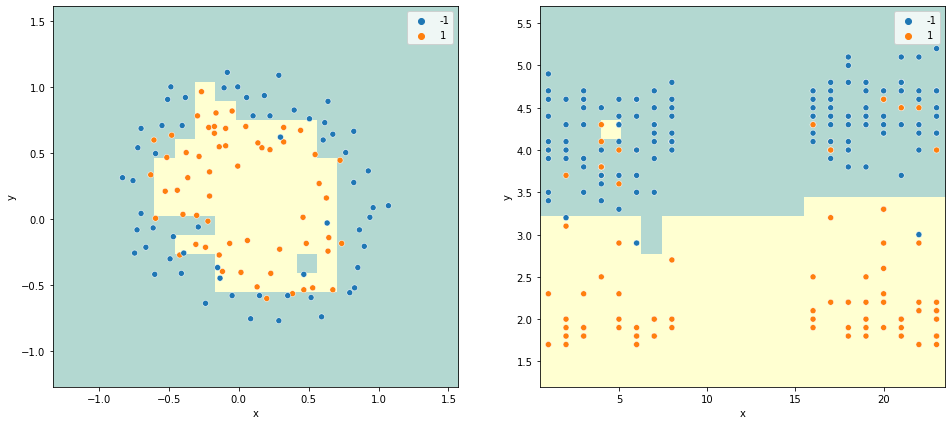

In [24]:
df1 = pd.read_csv('../lab3_SVM/data/chips.csv')
df2 = pd.read_csv('../lab3_SVM/data/geyser.csv')

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
clf = RandomForestClf(300, lambda n: 14 * np.sqrt(n), 5)

clf.fit(*df_to_data(df1))
show_image(df1, ax[0], clf)

clf.fit(*df_to_data(df2))
show_image(df2, ax[1], clf)

In [25]:
class AdaBoostClf:
    def __init__(self, est_cnt, max_depth=3, iters=10):
        self.trees = [TreeClf(max_depth, iters) for _ in range (est_cnt)]
        self.b = np.ones(est_cnt)
        self.ws = None
        self.X = None
        self.iter = None

    def init(self, X, y):
        self.X = X
        self.y = y
        self.iter = 0
        self.ws = [1 / len(self.X) for _ in self.X]
        return self

    def next_iteration(self):
        self.trees[self.iter].fit(self.X, self.y, self.ws)
        self.iter += 1
        b_clf_i = self.iter - 1
        bad_sc = self.__bad(self.trees[b_clf_i])
        self.b[b_clf_i] = 0.5 * np.log((1 - bad_sc) / bad_sc)
        for i in range(len(self.ws)):
            f = self.trees[b_clf_i].predict(self.X[i])
            self.ws[i] = self.ws[i] * np.exp(-self.b[b_clf_i] * self.y[i] * f)
            s = sum(self.ws)
            for i in range(len(self.ws)):
                self.ws[i] /= s

    def fit(self, X, y):
        self.init(X, y)
        for i in range(len(self.trees)):
            self.next_iteration()

    def predict(self, x):
        return np.sign(sum([self.b[i] * self.trees[i].predict(x) for i in range(self.iter)]))

    def __bad(self, clf):
        res = 0
        for i in range(len(self.X)):
            y_pred = clf.predict(self.X[i])
            if y_pred != self.y[i]:
                res += self.ws[i]
        return res

 50%|█████     | 4/8 [00:00<00:00, 16.76it/s]

0.6942148760330579
0.7575757575757576
0.8333333333333333
0.8592592592592593


 75%|███████▌  | 6/8 [00:00<00:00, 12.98it/s]

0.8421052631578947
0.9016393442622951


100%|██████████| 8/8 [00:00<00:00,  9.08it/s]

0.9090909090909091
0.9075630252100839


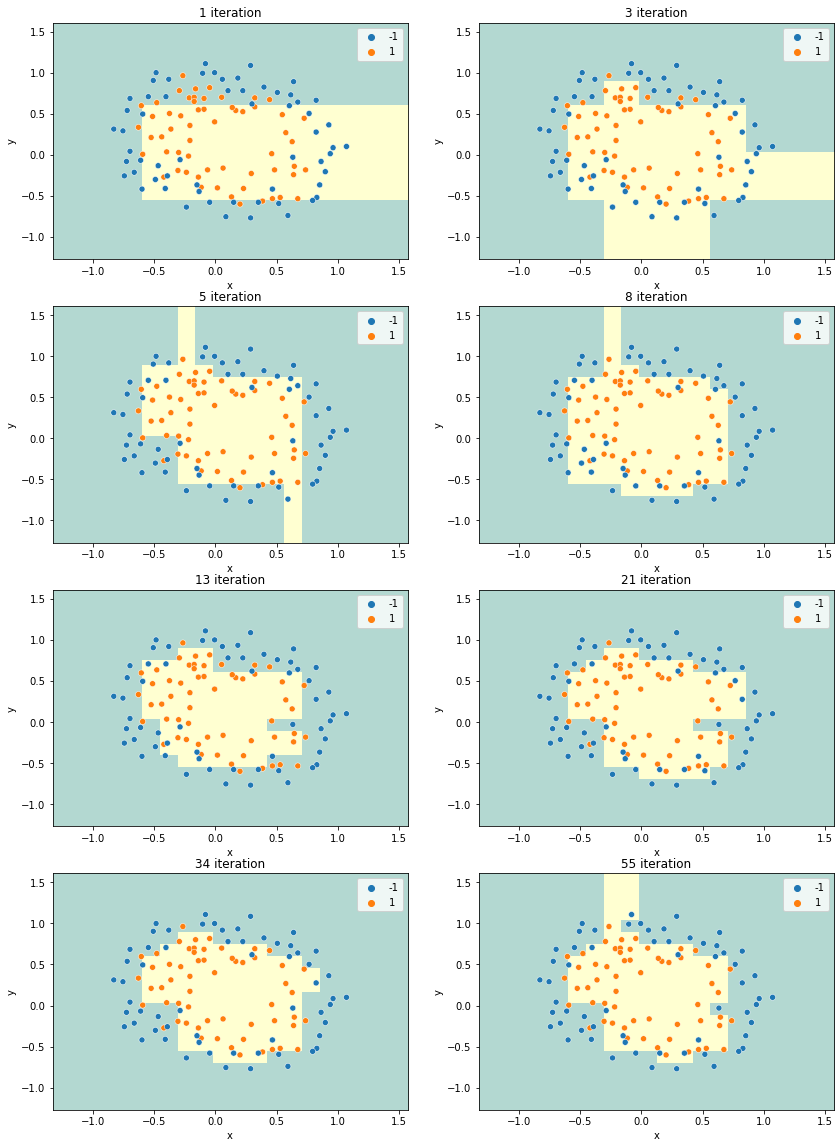

In [27]:
df3 = pd.read_csv("../lab3_SVM/data/chips.csv")
X, y = df_to_data(df3)

_, axs = plt.subplots(4, 2, figsize=(14, 20))

clf = AdaBoostClf(55, iters=2).init(X, y)
iters = [0, 1, 3, 5, 8, 13, 21, 34, 55]
for t in tqdm(range(len(iters) - 1)):
    for j in range(iters[t], iters[t + 1]):
        clf.next_iteration()
    show_image(df3, axs[t // 2, t % 2], clf)
    axs[t // 2, t % 2].set_title(f'{iters[t + 1]} iteration')

100%|██████████| 1000/1000 [01:43<00:00,  9.62it/s]


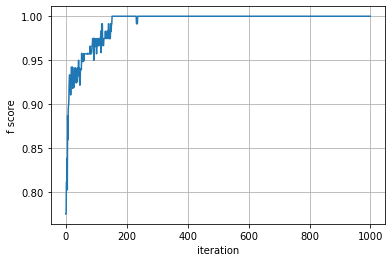

In [28]:
clf = AdaBoostClf(1000, 3, 8).init(X, y)
iters = list(range(0, 1000))
fs = []
for t in tqdm(iters):
    clf.next_iteration()
    y_pred = [clf.predict(x) for x in X]
    fs.append(f1_score(y, y_pred))

plt.grid()
plt.xlabel('iteration')
plt.ylabel('f score')
plt.plot(iters, fs)

100%|██████████| 200/200 [00:06<00:00, 31.37it/s]


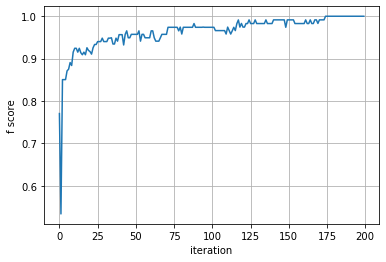

In [29]:
clf = AdaBoostClf(200, 3, 8).init(X, y)
iters = list(range(0, 200))
fs = []
for t in tqdm(iters):
    clf.next_iteration()
    y_pred = [clf.predict(x) for x in X]
    fs.append(f1_score(y, y_pred))

plt.grid()
plt.xlabel('iteration')
plt.ylabel('f score')
plt.plot(iters, fs)